### arcgis.learn モジュールを使用したディープ ラーニング
* arcgis.learn モジュールを使用してSingle Shot Detectorにより道路のひび割れを検出するサンプル ノートブックです。
* 学習用のデータは[オープンデータとして公開されている](https://github.com/sekilab/RoadDamageDetector#download-road-damage-dataset)ものを使用しました
    * 出典: [Maeda, H. et al. (2018). Road Damage Detection and Classification Using Deep Neural Networks with Smartphone Images. Computer-Aided Civil and Infrastructure Engineering, 33(12), pp.1127-1141.](https://onlinelibrary.wiley.com/doi/abs/10.1111/mice.12387)
* 本ノートブックの実行には以下のパッケージおよびそれらの依存するパッケージが必要です
    * arcgis 1.7.0
    * fastai 1.0.54
    * pytorch 1.1.0
    * torchvision 0.3.0
    * scikit-image 0.15.0
    * opencv-python 4.0.1.24

### データのダウンロード

In [5]:
import six.moves.urllib as urllib
import os

In [6]:
import pathlib
from arcgis import learn
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
import cv2

In [7]:
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')

if not os.path.exists('./RoadDamageDataset.tar.gz'):
    url_base = 'https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/RoadDamageDataset.tar.gz'
    urllib.request.urlretrieve(url_base, './RoadDamageDataset.tar.gz')
    
    print("Download RoadDamageDataset.tar.gz Done")
    
else:
    print("You have RoadDamageDataset.tar.gz")

Download RoadDamageDataset.tar.gz Done


ダウンロードされた RoadDamageDataset.tar.gz ファイルを展開して下さい。
* 画像が撮影された各都市毎にディレクトリが別れています
* ファイル展開後に各都市のデータが格納されているディレクトリで以下の操作を行ってください
    * Windowsでは.DS_Storeファイル等が残るので削除
    * labelsフォルダは削除するか別のディレクトリへ移動
    * Annotationsフォルダの名前をlabelsに変更
    * JPEGImagesフォルダの名前をimagesに変更
    * ImageSetsフォルダ内のMainフォルダの階層を一つ上げる
    * ImageSetsフォルダは削除するか別のディレクトリへ移動

### 学習

In [9]:
dat_path = Path(r"RoadDamageDataset/Adachi/")

In [10]:
# DataBunch の作成
dat = learn.prepare_data(path = dat_path,
                         class_mapping = {"D00": "Liner crack, longitudinal, wheel mark part",
                                          "D01": "Liner crack, longitudinal, construction joint part",
                                          "D10": "Liner crack, lateral,equal interval",
                                          "D11": "Liner crack, lateral, construction joint part",
                                          "D20": "Alligator crack",
                                          "D40": "Rutting, bump, pothole, separation",
                                          "D43": "White line blur",
                                          "D44": "Cross walk blur"},
                         batch_size = 128,
                         chip_size = 450,
                         seed = 42,
                         dataset_type = "PASCAL_VOC_rectangles",
                         resize_to = 450)

Please check your dataset. 58 images dont have the corresponding label files.


In [11]:
# クラスの確認
dat.classes

['background',
 'Alligator crack',
 'Cross walk blur',
 'Liner crack, lateral, construction joint part',
 'Liner crack, lateral,equal interval',
 'Liner crack, longitudinal, construction joint part',
 'Liner crack, longitudinal, wheel mark part',
 'Rutting, bump, pothole, separation',
 'White line blur']

/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py:306: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


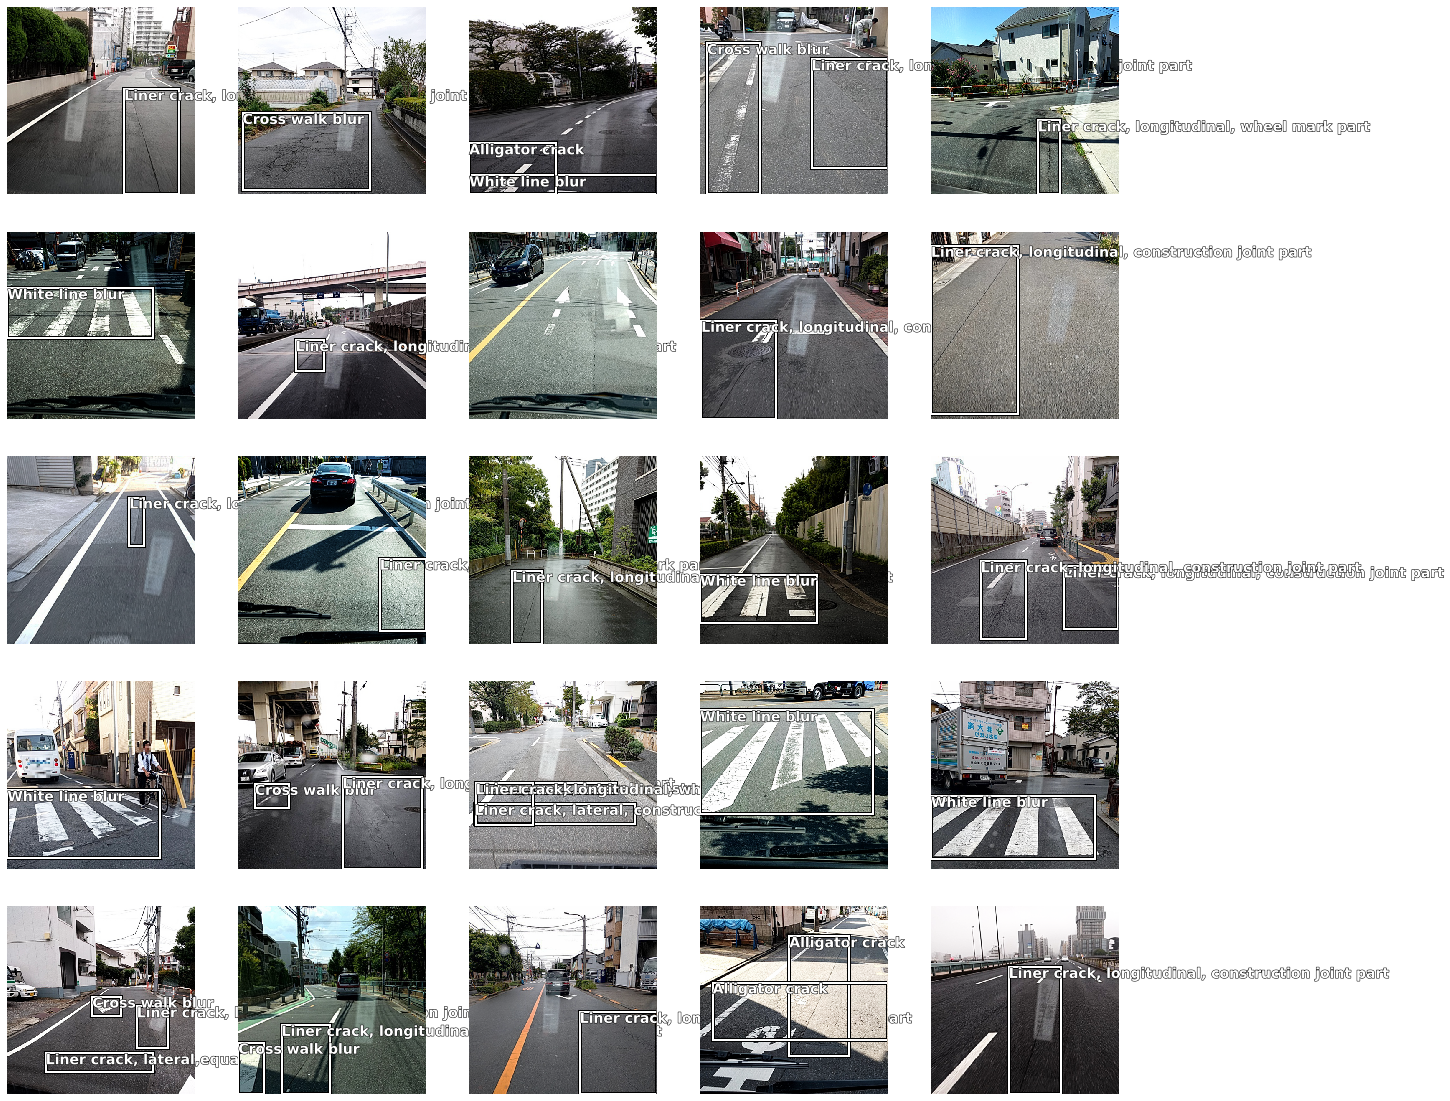

In [13]:
dat.show_batch()

In [10]:
# SingleShotDetectorクラスの作成
ssd = learn.SingleShotDetector(data = dat,
                               grids = [3, 3],
                               zooms = [1.0],
                               ratios = [[1.0, 1.0]],
                               backbone = "resnet50",
                               focal_loss = True)

In [27]:
# 学習(マシンスペックによりますが、時間がかかるので注意してください)
# 元のデータの画像とラベルの数が一致していないため、エラーが発生することがあります。
# その場合、prepare_data()メソッドのseed値を変更するなどすると解消されることがあります。
ssd.fit(lr = slice(1e-03, 1e-02))

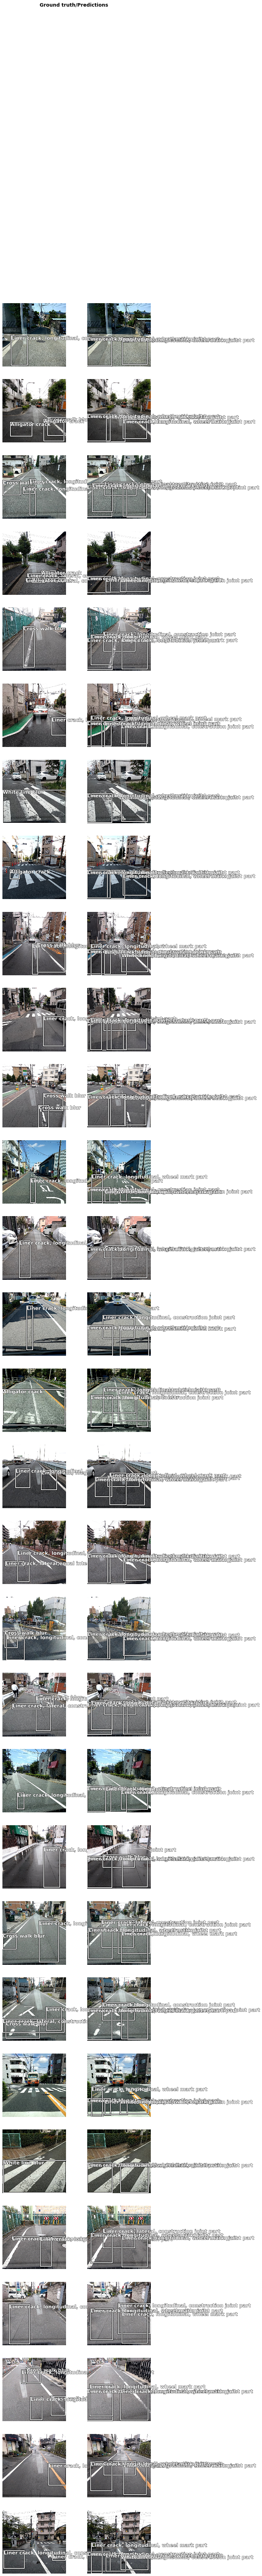

In [28]:
# 学習結果の確認
ssd.show_results(thresh=0.1, rows = 30)

In [29]:
# モデルの保存。学習データのディレクトリ内にmodelsフォルダが作成されており、そこに保存されます。
ssd.save(r"stage-1_2")

PosixPath('RoadDamageDataset/Adachi/models/stage-1_2')

In [7]:
# モデルのロード
ssd.load(r"stage-1_2")

In [8]:
# 再度学習
ssd.fit(epochs = 15, lr = slice(1e-03, 1e-02))

In [16]:
ssd.save(r"stage-2")

In [14]:
ssd.load(r"stage-2")

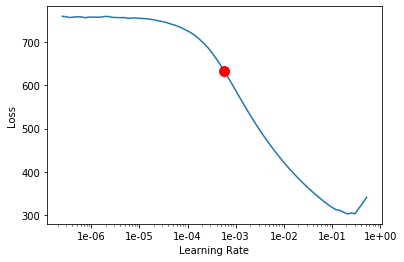

0.0005754399373371565

In [20]:
# 学習時に渡す学習率の目安を lr_find() メソッドで確認できます(学習と同様実行に時間がかかります)
ssd.lr_find()

In [16]:
ssd.fit(lr = slice(1e-04, 1e-02))

In [17]:
ssd.save("stage-3-fine")

PosixPath('RoadDamageDataset/Adachi/models/stage-3-fine')

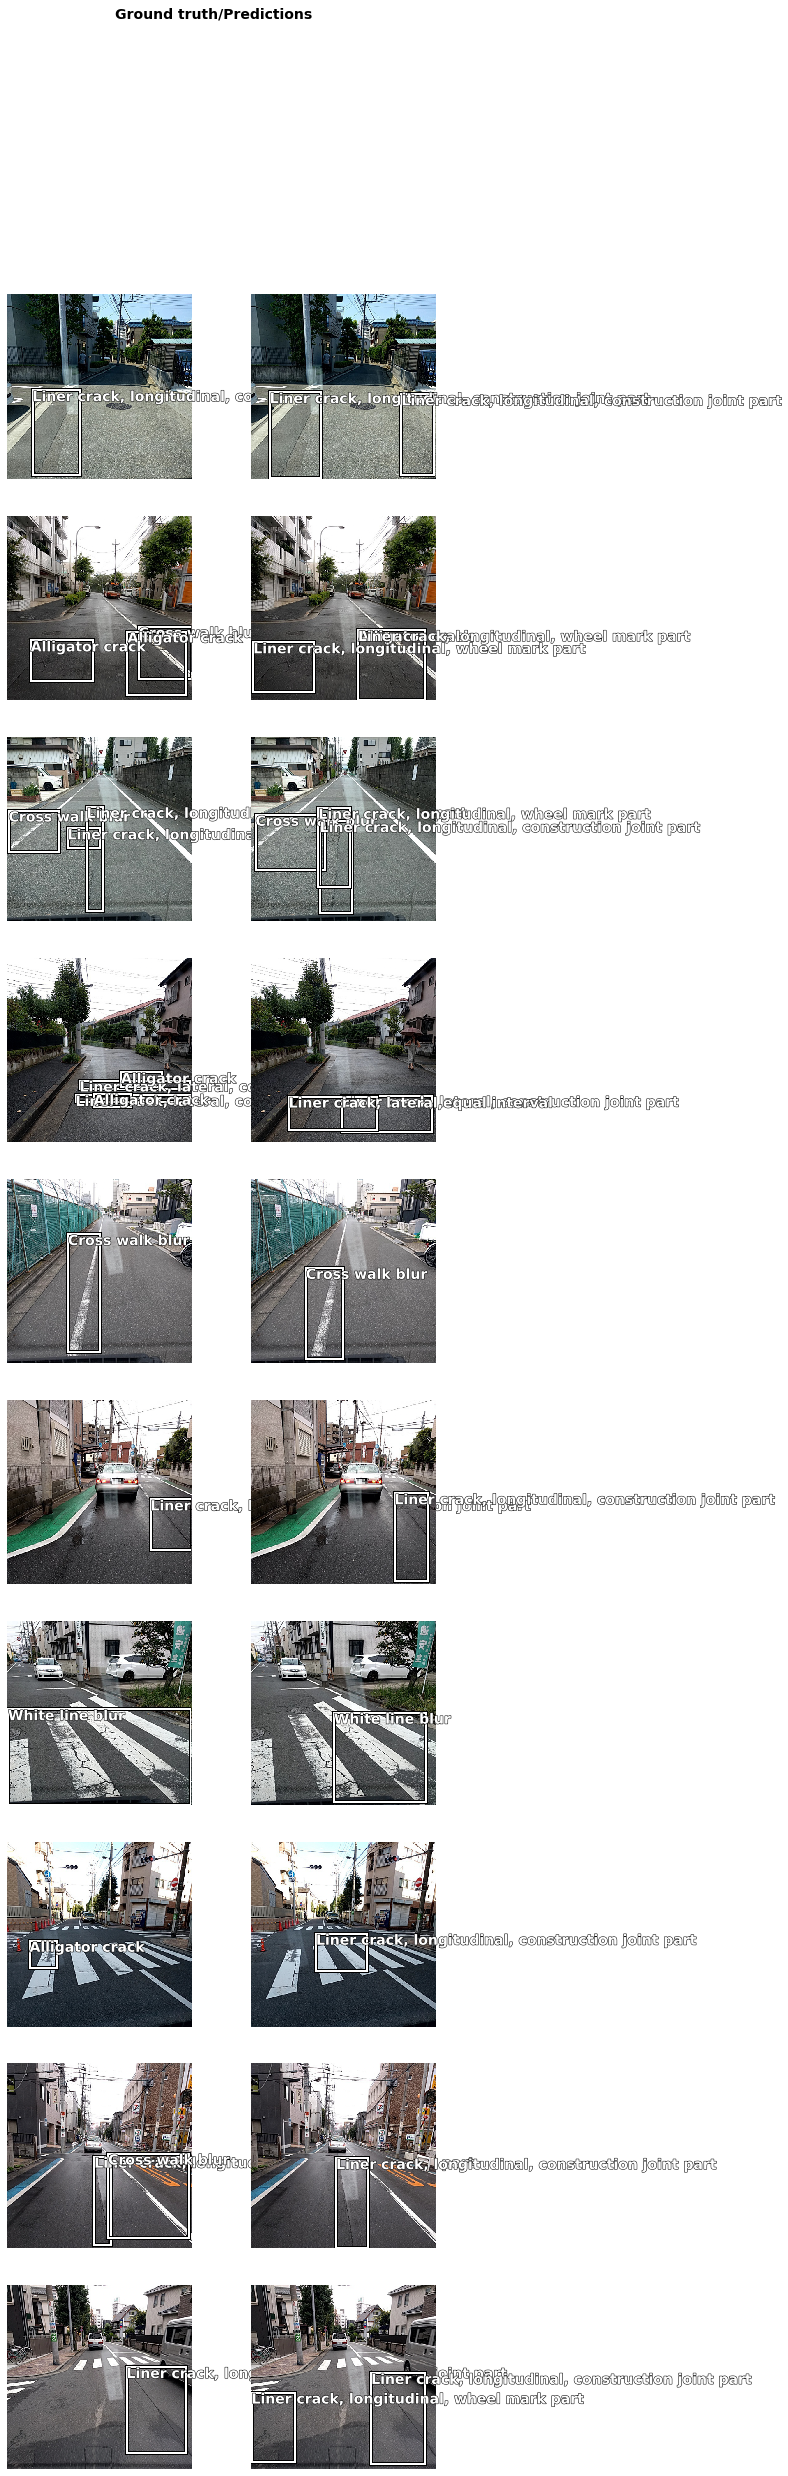

In [18]:
ssd.show_results(rows = 10, thresh = 0.2)